[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/home/codespace/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.8622710622710623
Precision: 0.8760035682426405
Recall: 0.9524733268671193
F1 Score: 0.912639405204461
ROC-AUC: 0.7681528310982303


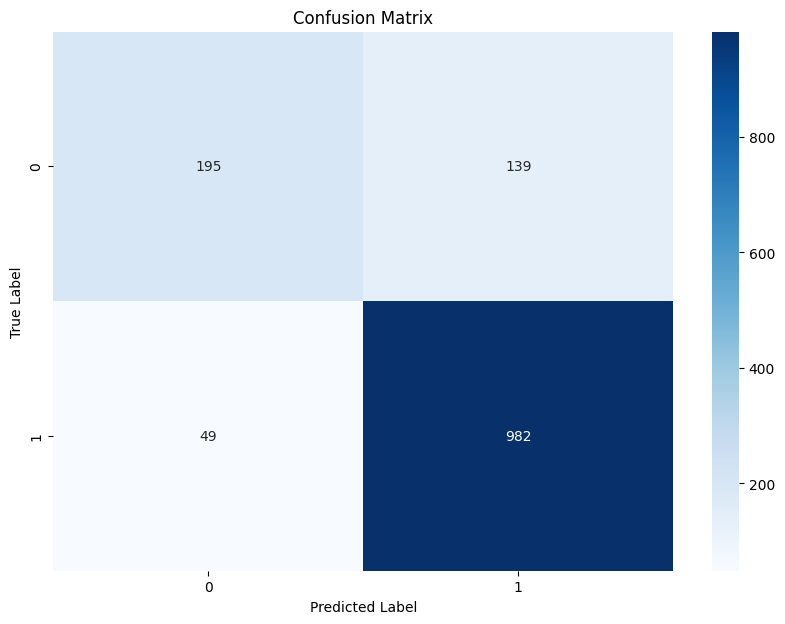

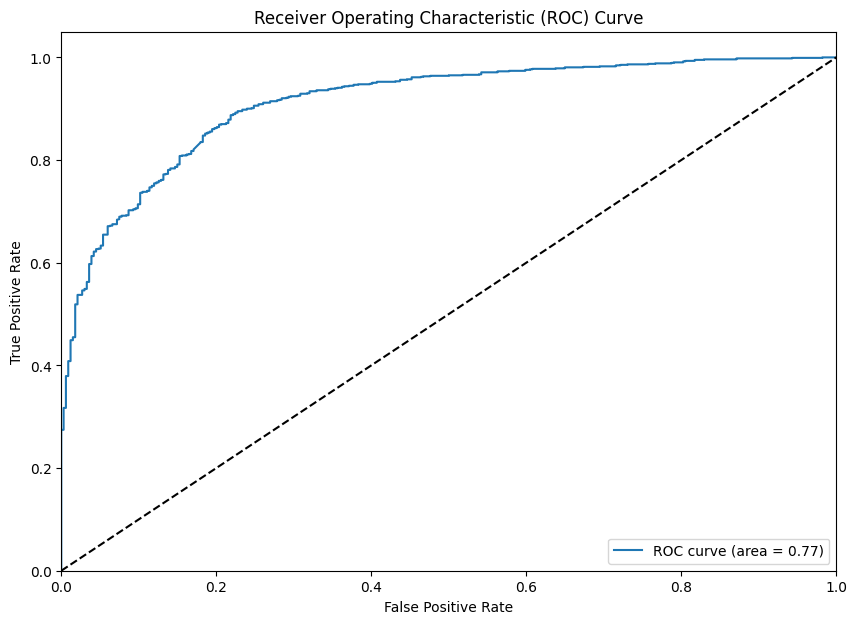

In [12]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# 자연어 처리를 위해 nltk 데이터 다운로드합니다.
nltk.download('punkt') # 문장, 단어 토큰화를 위해 필요한 데이터를 다운로드합니다.
nltk.download('stopwords') # 불용어 리스트를 다운로드합니다.
nltk.download('wordnet') # 표제어 추출을 위한 wordnet 데이터를 다운로드합니다.
nltk.download('averaged_perceptron_tagger') #품사 태깅을 위한 모델을 다운로드합니다.

# 아마존 신발 제품 리뷰 데이터를 로드합니다.
file_path = 'amazon_uk_shoes_products_dataset_2021_12.csv'
df = pd.read_csv(file_path)

# 결측값을 처리합니다.
df['review_text'] = df['review_text'].fillna('')

# 노이즈를 제거하기 위한 함수
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # HTML 태그 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # URL 제거
    text = re.sub(r'\@\w+|\#', '', text)  # @ 및 # 제거
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 알파벳과 공백을 제외한 모든 문자 제거
    text = text.lower()  # 소문자 변환
    return text

# 텍스트 정리
df['cleaned_review_text'] = df['review_text'].apply(clean_text)

# 문장, 단어를 토큰화 및 불용어를 제거합니다.
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

df['tokens'] = df['cleaned_review_text'].apply(tokenize_and_remove_stopwords)

# 스테밍 및 표제어를 추출합니다.
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """단어의 품사를 반환하는 함수"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def stem_and_lemmatize(tokens):
    stemmed = [ps.stem(word) for word in tokens]
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in stemmed]
    return lemmatized

df['processed_tokens'] = df['tokens'].apply(stem_and_lemmatize)

# TF-IDF 벡터화합니다.
tfidf = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x)
X = tfidf.fit_transform(df['processed_tokens']).toarray()

# 레이블을 설정합니다. (평점이 4 이상이면 긍정, 아니면 부정으로 설정)
df['label'] = df['review_rating'].apply(lambda x: 1 if x >= 4 else 0)
y = df['label']

# 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 및 하이퍼파라미터 튜닝
# 기본 모델로 로지스틱 회귀 모형을 선택하였습니다.
model = LogisticRegression()

# 하이퍼파라미터 그리드 설정합니다.
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# 그리드 서치를 적용합니다.
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적의 모델
best_model = grid_search.best_estimator_

# 예측
y_pred = best_model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선을 생성합니다.
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
